In [1]:
# jupyter-notebook script1.ipynb --port 8883 --ip 192.168.7.21

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
from collections import Counter
import itertools  
from collections import defaultdict
import time

%matplotlib inline

In [2]:
def show_img(img):
    fig = plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img[height_margin:height_margin+displayed_sq,width_margin:width_margin+displayed_sq], cmap="ocean")

In [3]:
class ComponentsContainer():
    def __init__(self, binary, low):
        starttime = time.time()

        nbComponents, markers, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

        components_index = {}
        background_size = max(stats[:, -1])
        for i in range(len(stats)):
            if low < stats[i, -1] < background_size:
                components_index[i] = Component(stats[i, -1], centroids[i], i)
            else:
                markers[markers == i] = 0

        self.binary = binary
        self.markers = markers
        self.markers_backup = np.copy(markers)
        self.components_index = components_index
        self.components_index_backup = components_index.copy()
        self.nucleus_labs = list()
        self.axon_labs = list()

        self.add_edge_info_to_components()
        print("selecting components and size prefiltering took {} sec".format(time.time() - starttime))


  
    # add jit
    def add_edge_info_to_components(self):

        for i in range(1, self.markers.shape[0] - 1):
            for j in range(1, self.markers.shape[1] - 1):
                cur_lab = self.markers[i, j]
                if cur_lab in self.components_index.keys() and \
                        not cur_lab == \
                                self.markers[i, j + 1] == \
                                self.markers[i, j - 1] == \
                                self.markers[i + 1, j] == \
                                self.markers[i - 1, j]:
                    self.components_index[cur_lab].add_edge(np.array([i, j]))
                    self.components_index_backup[cur_lab].add_edge(np.array([i, j]))
    # add jit
    def merge_components_closer_than(self, centroid_t, contour_t):
        starttime = time.time()
        self.reload()
        all_pairs = itertools.combinations(self.components_index.keys(), 2)

        for first, second in all_pairs:
            close_flag, points = self.components_index.get(first).is_close(self.components_index.get(second),
                                                                           centroid_t, contour_t)
            if close_flag:
                self._merge_two_components(first, second, points)
        print("merging took {:3} sec".format(time.time() - starttime))

    def reload(self):
        print("discarding previous components merge and axon-nucleus spliting")
        self.markers = self.markers_backup
        self.components_index = self.components_index_backup
        self.nucleus_labs = list()
        self.axon_labs = list()

    def split_nucl_axon(self, threshold):
        starttime = time.time()
        self.nucleus_labs = list()
        self.axon_labs = list()
        
        for lab in self.components_index.keys():
            if not self.components_index.get(lab).label == lab:
                continue
            if self.components_index.get(lab).size > threshold:
                self.components_index[lab] = Nucleus.from_component(self.components_index[lab])
                self.nucleus_labs.append(lab)
            else:
                self.components_index[lab] = Axon.from_component(self.components_index[lab])
                self.axon_labs.append(lab)
        print("splitting completted in {}, \naxons: {}, nucl: {}".format(time.time() - starttime,
                                                                         len(self.axon_labs),
                                                                         len(self.nucleus_labs)))
        
    def group_axons_to_nucleus(self, centroid_t, contour_t):

        starttime = time.time()
        axons_with_nucl = 0
        for nucl_lab in self.nucleus_labs:
            nucl = self.components_index.get(nucl_lab)
            for axon_lab in self.axon_labs:
                axon = self.components_index.get(axon_lab)
                close, point = nucl.is_close(axon, centroid_t, contour_t)
                if (not axon.attached) and close:
                    nucl.axons.append(axon)
                    axon.attached = True
                    axons_with_nucl += 1
        print("grouping ax to nucl took {:3} sec\n axons with nucleus: {}".format(time.time() - starttime,
                                                                                  axons_with_nucl))


    def _merge_two_components(self, survivor_label, disappearing_label, joint_points):

        disappearing_label = self.get_correct_label(disappearing_label)
        survivor_label = self.get_correct_label(survivor_label)
        if survivor_label == disappearing_label:
            return

        self.components_index[survivor_label].size += self.components_index[disappearing_label].size
        self.components_index[survivor_label].edge.extend(self.components_index[disappearing_label].edge)
        self.components_index[disappearing_label].label = self.components_index[survivor_label].label

        self.markers[self.markers == disappearing_label] = survivor_label

        cv2.line(self.markers, (joint_points[0][1], joint_points[0][0]),
                 (joint_points[1][1], joint_points[1][0]), survivor_label, lineType=4,
                 thickness=2)

    def get_correct_label(self, label):
        if label == self.components_index.get(label).label:
            return label
        else:
            return self.get_correct_label(self.components_index.get(label).label)


    def draw_components(self):

        fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(self.markers[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq],
                   cmap="jet")

    def draw_nucl_and_axons(self):
        pic = np.zeros(self.markers.shape)
        nucl_color = 400
        axon_color = 455
        color_switch = 1
        switch_val = 100
        for nucl_lab in self.nucleus_labs:
            pic[self.markers == nucl_lab] = nucl_color
            for ax in self.components_index.get(nucl_lab).axons:
                pic[self.markers == ax.label] = axon_color

            nucl_color += color_switch * switch_val
            axon_color += color_switch * switch_val
            color_switch *= 1

        fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq],
                   cmap="jet")


class Component:
    def __init__(self, size, centroid, label):
        self.size = size
        self.centroid = centroid
        self.label = label
        self.edge = []

    @classmethod
    def from_component(cls, component):
        return cls(component.size, component.centroid, component.label, component.edge)

    def add_edge(self, point):
        self.edge.append(point)

    def is_close(self, second_comp, centroid_t, contour_t):
        if self.is_centroid_close(second_comp, centroid_t):
            return self.is_contour_close(second_comp, contour_t)
        else:
            return False, None

    def is_centroid_close(self, second_comp, thr):
        return np.linalg.norm(self.centroid - second_comp.centroid) < thr

    def is_contour_close(self, second_comp, thr):
        for first, second in itertools.product(self.edge, second_comp.edge):
            if np.linalg.norm(first - second) < thr:
                return True, (first, second)
        return False, None

    def is_nucleus(self):
        return False


class Nucleus(Component):
    def __init__(self, size, centroid, label, edge, axons=list()):
        super().__init__(size, centroid, label)
        if axons:
            self.axons = axons
        else:
            self.axons = list()
            
        self.edge = edge


    def is_nucleus(self):
        return True


class Axon(Component):
    def __init__(self, size, centroid, label, edge, attached=False):
        super().__init__(size, centroid, label)
        self.attached = attached
        self.edge = edge

In [4]:
displayed_sq = 1500
width_margin = 0
height_margin = 0

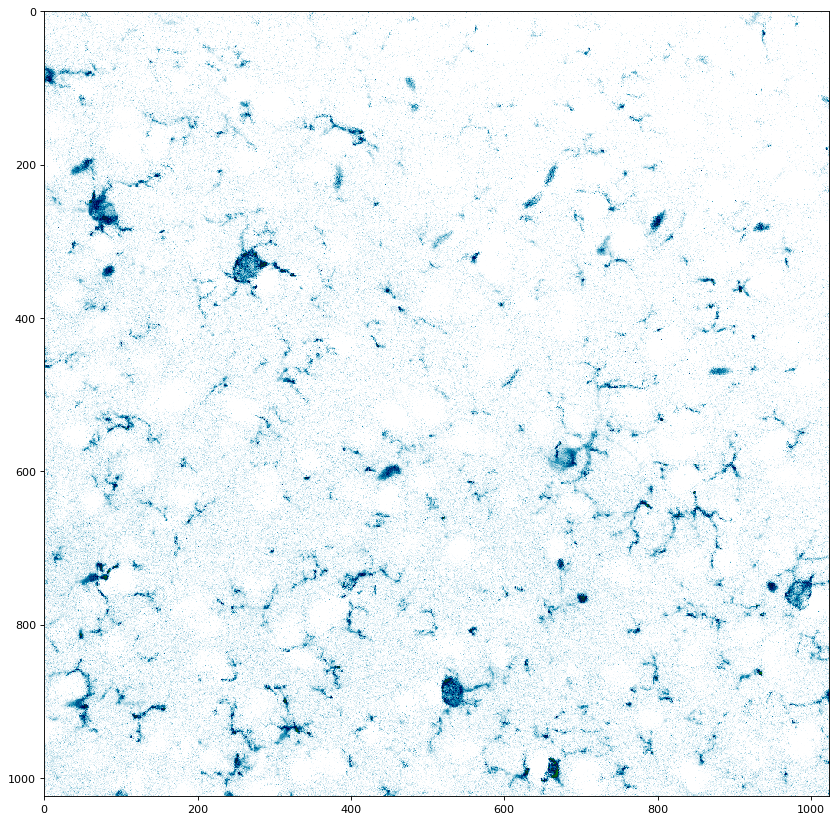

In [6]:
img = cv2.imread('../raw_pics/3.bmp')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invert = cv2.bitwise_not(gray)
show_img(invert)

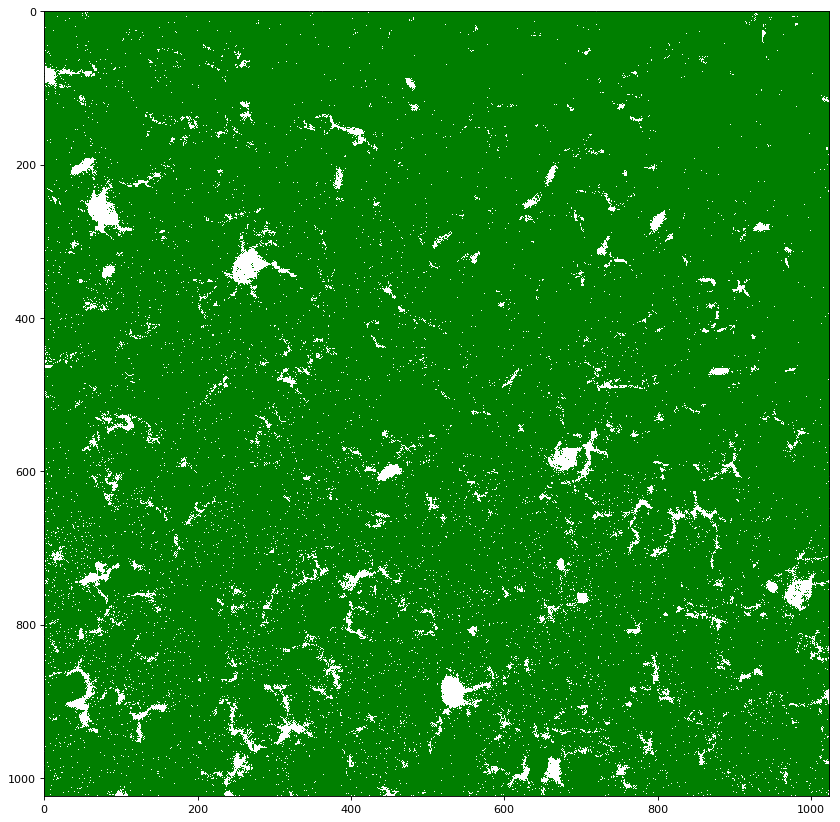

In [7]:
BACKGROUND_INTENSITY_THRESHOLD = 15

ret, binary = cv2.threshold(gray, BACKGROUND_INTENSITY_THRESHOLD, 255, cv2.THRESH_BINARY)
show_img(binary)

selecting components and size prefiltering took 12.06425666809082 sec


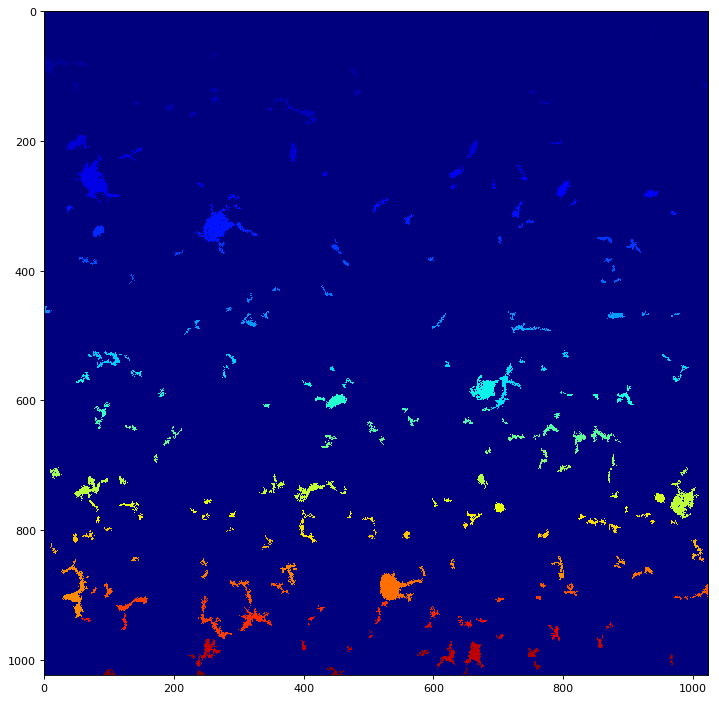

In [8]:
# filter all noise using minimum size threshold

MIN_AXON_SIZE = 30
container = ComponentsContainer(binary, MIN_AXON_SIZE)
container.draw_components()

discarding previous components merge and axon-nucleus spliting
merging took 72.50251007080078 sec


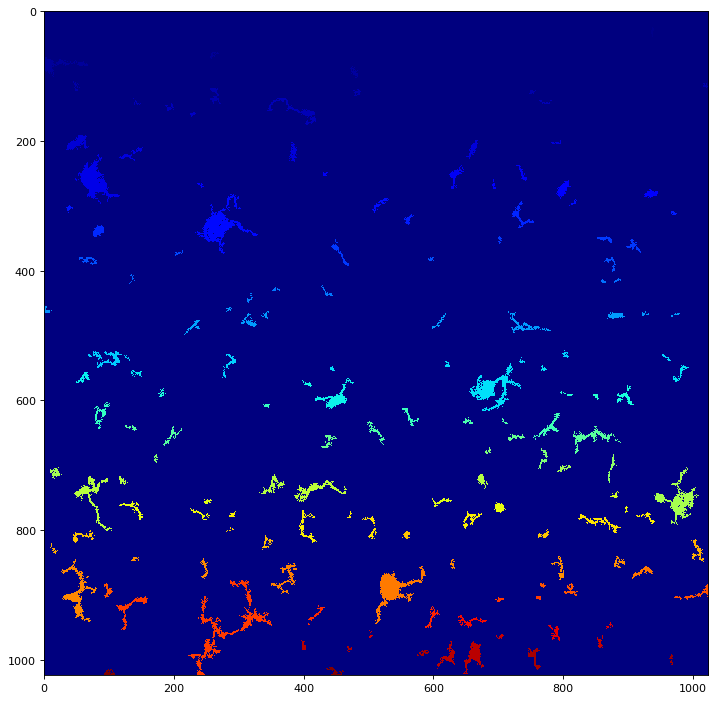

In [9]:
#merging close components based on centroids and contour distance

PREMERGE_CENTROIDS_DISTANCE_T  = 70
PREMERGE_CONTOUR_DISTANCE_T = 12

container.merge_components_closer_than(PREMERGE_CENTROIDS_DISTANCE_T, PREMERGE_CONTOUR_DISTANCE_T)
container.draw_components()

splitting completted in 0.0011987686157226562, 
axons: 135, nucl: 21


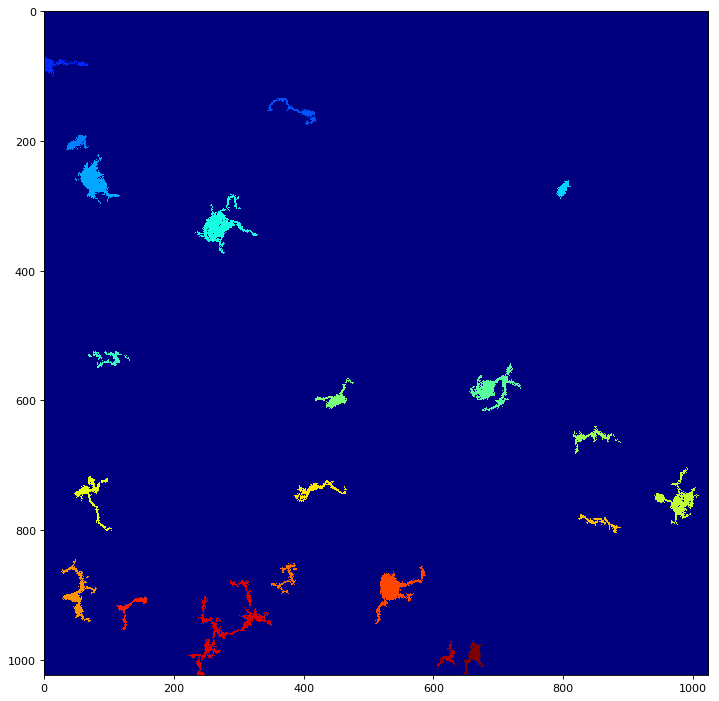

In [10]:
#splitting nucleus and axons based on size

MIN_NUCLEUS_SIZE = 290

container.split_nucl_axon(MIN_NUCLEUS_SIZE)
container.draw_nucl_and_axons()

grouping ax to nucl took 66.33072090148926 sec
 axons with nucleus: 0


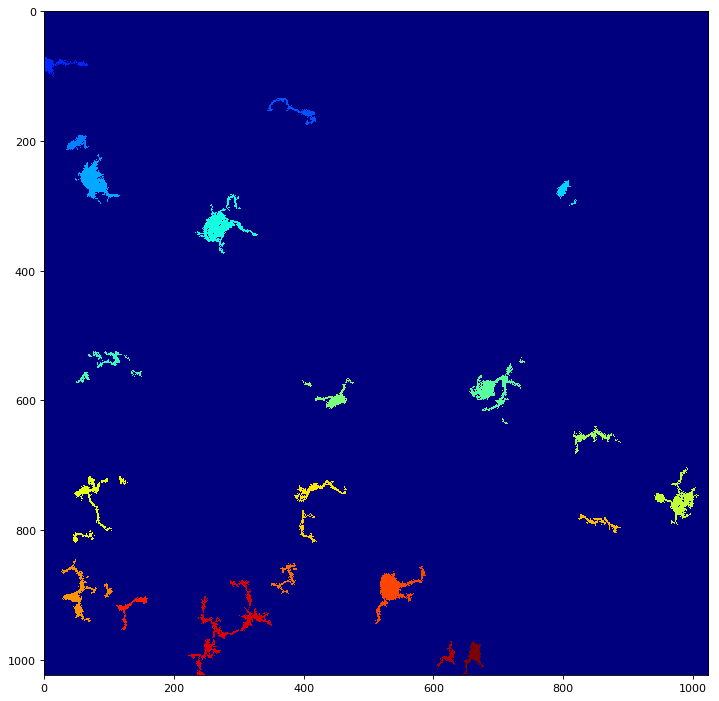

In [12]:
#grouping possible axons to nucleus

CENTROIDS_DISTANCE_T = 90
CONTOUR_DISTANCE_T = 18

container.group_axons_to_nucleus(CENTROIDS_DISTANCE_T, CONTOUR_DISTANCE_T)
container.draw_nucl_and_axons()

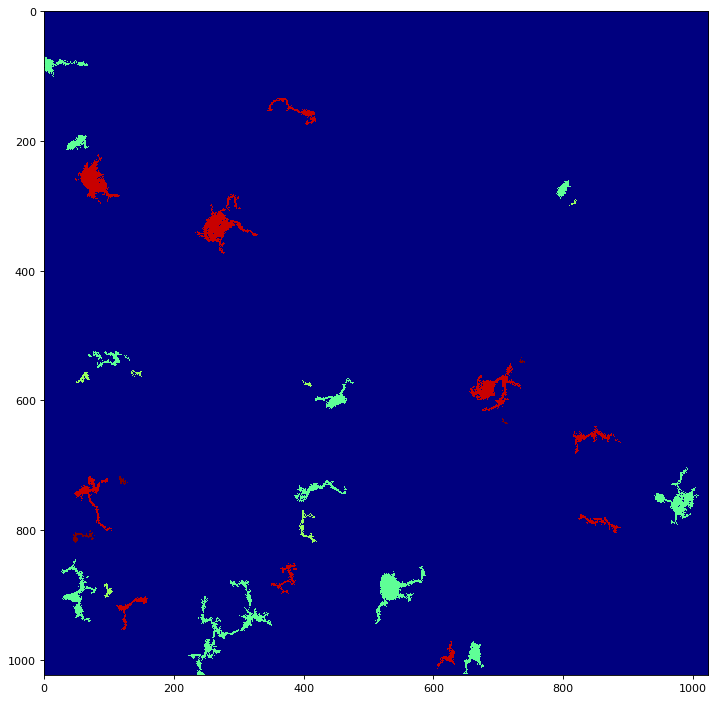

In [14]:
def draw_nucleus_from_container(container):
    
    pic = np.zeros(container.markers.shape)
    nucl_color = 400
    axon_color = 455
    color_switch = 1
    switch_val = 400
    for nucl_lab in container.nucleus_labs:
        pic[container.markers == nucl_lab] = nucl_color
        for ax in container.components_index.get(nucl_lab).axons:
             
            pic[container.markers == ax.label] = axon_color

        nucl_color += color_switch * switch_val 
        axon_color += color_switch * switch_val
        color_switch *= -1

    
        
    fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq],
                   cmap="jet")
    
draw_nucleus_from_container(container)

In [ ]:
# to do
# Write function to compute distance between contours. 

# more ideas:
# search for axons form axons
# implement contour filtering of axons
# add intensity related features
# Check if two centroids is closely contcted and merge them if needed.